In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Building an End-to-End Image Classifier with CNNs.**

Verify Dataset:

In [2]:
import os

# Define dataset path
train_dir = "/content/drive/MyDrive/FruitinAmazon/train/"
test_dir = "/content/drive/MyDrive/FruitinAmazon/test/"

# Get class names (subdirectories)
class_names = sorted(os.listdir(train_dir))

if not class_names:
    print("No class directories found in the train folder!")
else:
    print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


Check for Corrupted Images:

In [3]:
from PIL import Image, UnidentifiedImageError
corrupted_images = []  # List to store corrupted images path
# Loop through each class folder and check for corrupted images
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):  # Ensure it's a valid directory
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)
# Print results
if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")


No corrupted images found.


Count class Balance:

In [4]:
# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        # Filter images with valid extensions
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)  # Count images in each class
# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


Select Random Images for Visualization:

In [5]:
import random
selected_images = []  # Store image paths
selected_labels = []  # Store corresponding class names
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:  # Ensure the class folder is not empty
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

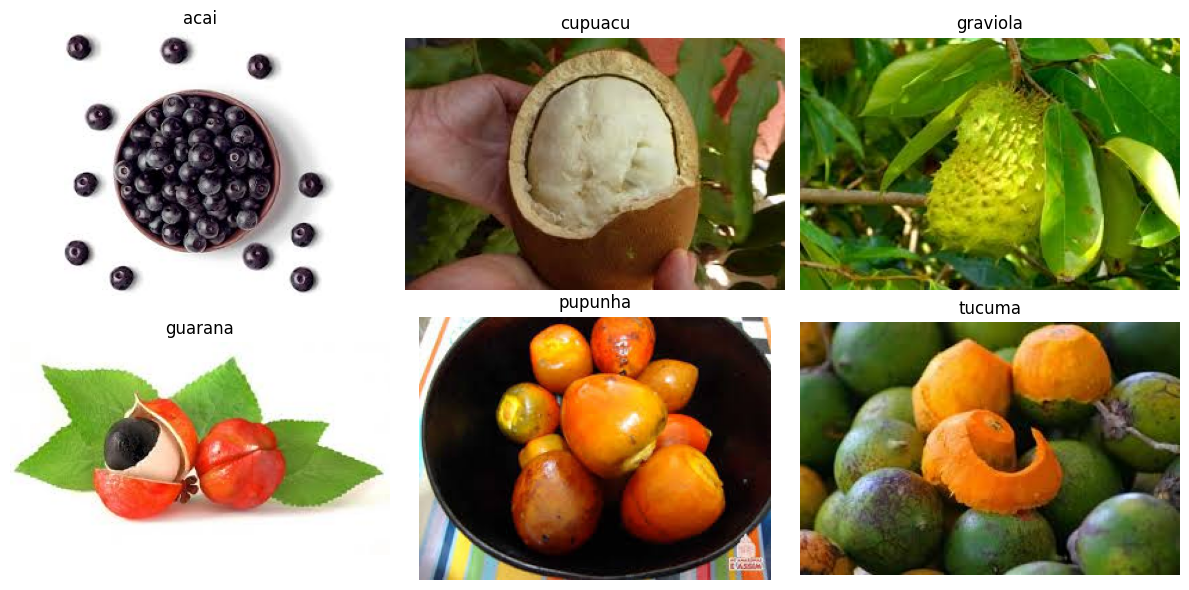

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2  # Determine columns
rows = 2  # Fixed rows for layout
# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
# Flatten axes to handle cases where the number of images is less than the grid size
axes = axes.flatten() if num_classes > 1 else [axes]
for i, ax in enumerate(axes):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis("off")
    else:
        ax.axis("off")  # Hide empty subplots
plt.tight_layout()
plt.show()

**Data Generation and Pre - processing:**

In [7]:
import tensorflow as tf
from tensorflow import keras
image_size = (28, 28)
batch_size = 32
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",  # Corrected: "both" is not valid; use "training"
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",  # Corrected: Separate call for validation data
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [8]:
# Take one batch from the training dataset and print its shape
for images, labels in train_ds.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Images shape: (32, 28, 28, 3)
Labels shape: (32,)


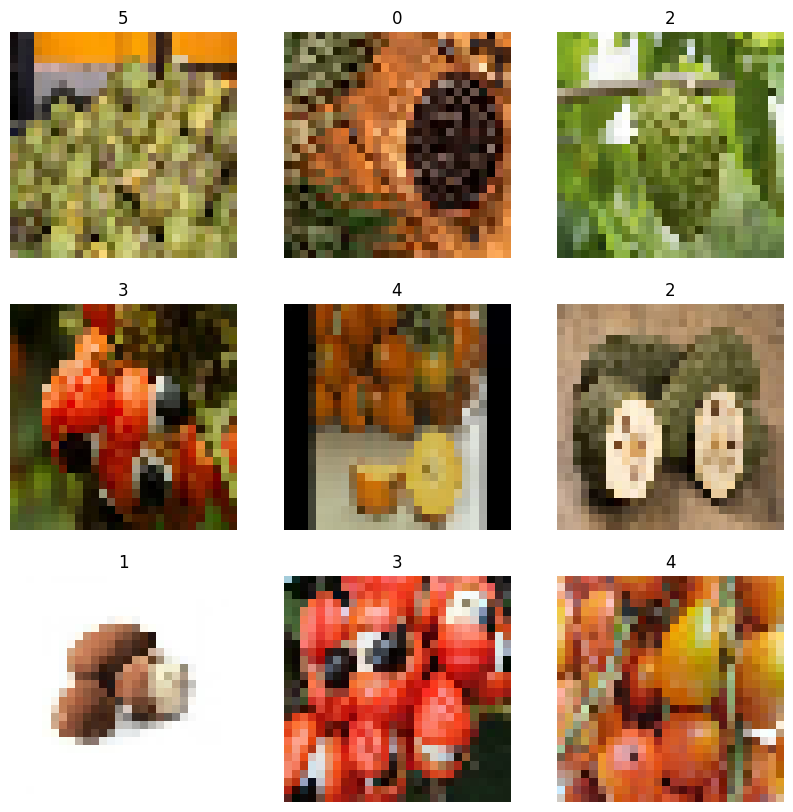

In [10]:
import numpy as np
plt.figure(figsize=(10, 10))
# Take one batch of images from the dataset
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))  # Ensure label is an integer
        plt.axis("off")  # Hide axes for better visualization
plt.show()

Data Augmentation with Keras:

In [11]:
from tensorflow.keras import layers
# This is a sample implementation, Thus I only use two augmentation, you can use more than two augmentation type for your project.
# Please check keras documentations for other available augmentation techniques.
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [12]:
# Define the model
model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    # Include augmentation layers before the model layers
    *data_augmentation_layers,

    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(10, activation="softmax")  # Assuming 10 classes for classification
])
# Print model summary to verify the structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 127008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │       1,270,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,270,986 (4.85 MB)

 Trainable params: 1,270,986 (4.85 MB)

 Non-trainable params: 0 (0.00 B)

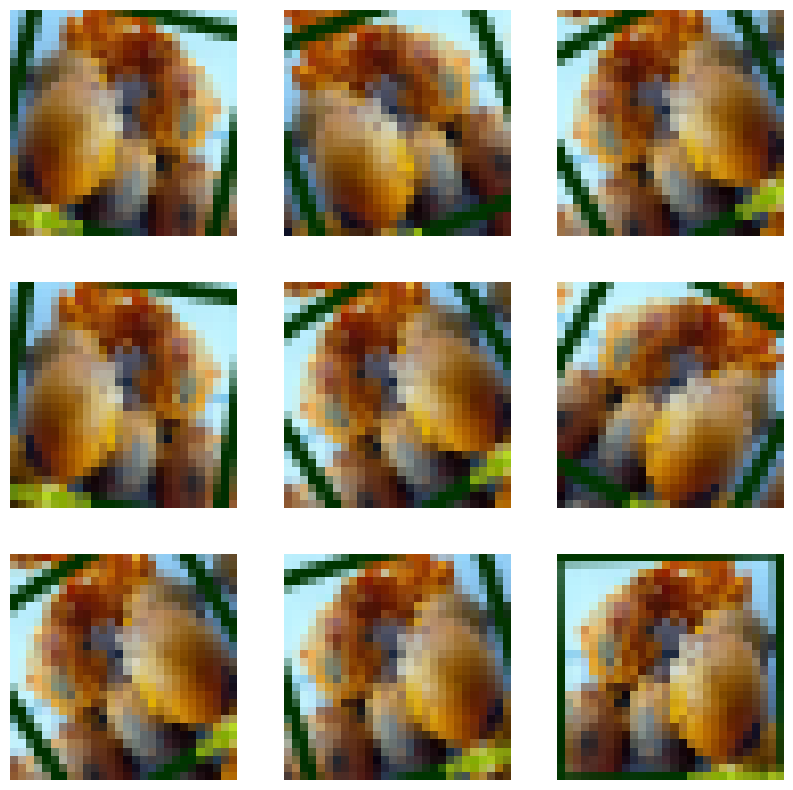

In [13]:
plt.figure(figsize=(10, 10))
# Take one batch from train_ds
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)  # Apply augmentation
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")  # Hide axes for better visualization
plt.show()

**Data Pre - processing: Scaling the data with Keras:**

In [14]:
# Apply data augmentation first, then rescaling
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [15]:
# Define input shape
input_shape = (28, 28, 3)  # Adjust according to your dataset
# Define the model with rescaling inside
inputs = keras.Input(shape=input_shape)
# Apply data augmentation
x = data_augmentation(inputs)
# Normalize pixel values to [0,1]
x = layers.Rescaling(1./255)(x)
# Add more layers (example CNN model)
x = layers.Conv2D(32, (3,3), activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation="softmax")(x)  # Adjust for your number of classes
# Create model
model = keras.Model(inputs, x)
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          54,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,986 (214.79 KB)

 Trainable params: 54,986 (214.79 KB)

 Non-trainable params: 0 (0.00 B)

BatchNormalization Class in Keras:

In [16]:
from tensorflow.keras.layers import BatchNormalization
layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
beta_initializer="zeros", gamma_initializer="ones")

Dropout Class in Keras:

In [17]:
from tensorflow.keras.layers import Dropout
# Example usage with rate as 0.5 (50% dropout)
layer = Dropout(rate=0.5, noise_shape=None, seed=None)

In [18]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Sequential

# Define data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

# Data augmentation function
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Define the model using the Sequential API with a list of layers
model = Sequential([
    # Data augmentation applied using Lambda layer
    layers.Lambda(data_augmentation, input_shape=(224, 224, 3)),
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten the output of the last Conv2D layer
    Flatten(),

    # First Fully Connected Layer
    Dense(512, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Second Fully Connected Layer
    Dense(256, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Third Fully Connected Layer
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Fourth Fully Connected Layer
    Dense(64, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output Layer with 10 neurons (for classification task with 10 classes)
    Dense(10, activation='softmax')
])

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use this for integer labels
    metrics=['accuracy']
)

# Summary of the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,257,930 (100.17 MB)

 Trainable params: 26,255,050 (100.16 MB)

 Non-trainable params: 2,880 (11.25 KB)

**Task - 1:**

1. Add Data Augmentation


In [22]:
# Step 1: Rescale Layer
rescale = tf.keras.layers.Rescaling(1./255)

# Step 2: Reload raw dataset
train_ds_raw = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(128, 128),
    batch_size=32
)

# Step 3: Data Augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Step 4: Apply augmentation + rescale
train_ds_augmented = train_ds_raw.map(lambda x, y: (data_augmentation(rescale(x)), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.


2. Build Improved Model (Deeper CNN with BN & Dropout)

In [25]:
from tensorflow.keras import layers, models

model_improved = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

3. Compile, Train & Evaluate

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Resize images to a larger size (128x128 or 224x224) to match the model input
image_size = (128, 128)  # Change to 224x224 if needed

# Load the training and validation datasets
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Load the test dataset
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,  # Make sure to provide the correct test data directory
    image_size=image_size,
    batch_size=batch_size,
)

# Define the model (modify the input shape accordingly)
model_improved = Sequential([
    layers.Input(shape=(image_size[0], image_size[1], 3)),
    layers.Rescaling(1./255),  # Normalize pixel values

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(),

    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(6, activation="softmax"),  # Adjust number of classes here to 6 for your dataset
])

# Compile the model
model_improved.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model with augmented data
history_improved = model_improved.fit(
    train_ds,  # Train dataset with resizing applied
    validation_data=val_ds,  # Validation dataset
    epochs=50,  # Number of epochs to train
    callbacks=[early_stopping, model_checkpoint]  # Callbacks for early stopping and saving the best model
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_improved.evaluate(test_ds)  # Test dataset evaluation
print(f"Improved Test Accuracy: {test_accuracy*100:.2f}%")

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Found 30 files belonging to 6 classes.
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.0596 - loss: 3.8828

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 797ms/step - accuracy: 0.0621 - loss: 4.1596 - val_accuracy: 0.1111 - val_loss: 2.6229
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.2350 - loss: 2.2951

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 756ms/step - accuracy: 0.2352 - loss: 2.2663 - val_accuracy: 0.2778 - val_loss: 1.9013
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4491 - loss: 1.6186

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 706ms/step - accuracy: 0.4549 - loss: 1.6039 - val_accuracy: 0.3333 - val_loss: 1.8037
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.5602 - loss: 1.2151

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 754ms/step - accuracy: 0.5590 - loss: 1.2187 - val_accuracy: 0.3889 - val_loss: 1.6599
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step - accuracy: 0.7678 - loss: 0.8806 - val_accuracy: 0.3889 - val_loss: 2.3034
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.7639 - loss: 0.7377

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7708 - loss: 0.7250 - val_accuracy: 0.3889 - val_loss: 1.6050
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - accuracy: 0.8524 - loss: 0.5019 - val_accuracy: 0.4444 - val_loss: 2.3630
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 561ms/step - accuracy: 0.8524 - loss: 0.3842 - val_accuracy: 0.5556 - val_loss: 1.9079
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 554ms/step - accuracy: 0.9714 - loss: 0.1551 - val_accuracy: 0.6111 - val_loss: 1.6844
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 1.1151
Improved Test Accuracy: 50.00%


**Task - 2**

1. Load VGG16 (without top)

In [32]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


2. Add Custom Layers

In [33]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=output)

3. Preprocess Dataset to Match VGG16 Requirements (224x224)

In [34]:
img_size = 224

train_ds_vgg = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
val_ds_vgg = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
test_ds_vgg = image_dataset_from_directory(
    test_dir,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False
)

# Normalize
rescale_vgg = tf.keras.layers.Rescaling(1./255)
train_ds_vgg = train_ds_vgg.map(lambda x, y: (rescale_vgg(x), y))
val_ds_vgg = val_ds_vgg.map(lambda x, y: (rescale_vgg(x), y))
test_ds_vgg = test_ds_vgg.map(lambda x, y: (rescale_vgg(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Found 30 files belonging to 6 classes.


4. Compile & Train

In [35]:
model_vgg.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_vgg = model_vgg.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1337 - loss: 2.0336 

3/3 ━━━━━━━━━━━━━━━━━━━━ 60s 18s/step - accuracy: 0.1419 - loss: 2.0210 - val_accuracy: 0.1111 - val_loss: 1.8793 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1696 - loss: 1.8085 

3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 18s/step - accuracy: 0.1723 - loss: 1.8074 - val_accuracy: 0.1667 - val_loss: 1.9179 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.3142 - loss: 1.7307 

3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 19s/step - accuracy: 0.3190 - loss: 1.7252 - val_accuracy: 0.2222 - val_loss: 1.8884 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.3142 - loss: 1.7106 

3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 18s/step - accuracy: 0.3190 - loss: 1.7011 - val_accuracy: 0.3889 - val_loss: 1.8183 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3796 - loss: 1.5583 

3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 18s/step - accuracy: 0.3819 - loss: 1.5516 - val_accuracy: 0.4444 - val_loss: 1.7344 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 62s 20s/step - accuracy: 0.4783 - loss: 1.5156 - val_accuracy: 0.3889 - val_loss: 1.6655 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 23s/step - accuracy: 0.5699 - loss: 1.3466 - val_accuracy: 0.4444 - val_loss: 1.6200 - learning_rate: 0.0010
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 22s/step - accuracy: 0.4727 - loss: 1.4138 - val_accuracy: 0.3889 - val_loss: 1.5953 - learning_rate: 0.0010
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5648 - loss: 1.3411 

3/3 ━━━━━━━━━━━━━━━━━━━━ 56s 18s/step - accuracy: 0.5660 - loss: 1.3342 - val_accuracy: 0.5000 - val_loss: 1.5849 - learning_rate: 0.0010
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 22s/step - accuracy: 0.6497 - loss: 1.2387 - val_accuracy: 0.5000 - val_loss: 1.5554 - learning_rate: 0.0010
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 74s 18s/step - accuracy: 0.6584 - loss: 1.1350 - val_accuracy: 0.5000 - val_loss: 1.5357 - learning_rate: 0.0010
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 23s/step - accuracy: 0.6970 - loss: 1.0643 - val_accuracy: 0.5000 - val_loss: 1.5375 - learning_rate: 0.0010
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 18s/step - accuracy: 0.6576 - loss: 1.1270 - val_accuracy: 0.5000 - val_loss: 1.5304 - learning_rate: 0.0010
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 23s/step - accuracy: 0.7075 - loss: 1.0313 - val_accuracy: 0.5000 - val_loss: 1.5281 - learning_rate: 0.0010
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7297 - loss: 1.0159 

3/3 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step - accuracy: 0.7313 - loss: 1.0113 - val_accuracy: 0.5556 - val_loss: 1.5015 - learning_rate: 0.0010
Epoch 16/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 18s/step - accuracy: 0.6979 - loss: 0.9757 - val_accuracy: 0.5000 - val_loss: 1.4718 - learning_rate: 0.0010
Epoch 17/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 18s/step - accuracy: 0.8385 - loss: 0.8157 - val_accuracy: 0.5556 - val_loss: 1.4376 - learning_rate: 0.0010
Epoch 18/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 23s/step - accuracy: 0.7005 - loss: 0.9531 - val_accuracy: 0.5000 - val_loss: 1.4164 - learning_rate: 0.0010
Epoch 19/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 22s/step - accuracy: 0.7066 - loss: 0.9867 - val_accuracy: 0.5000 - val_loss: 1.4088 - learning_rate: 0.0010
Epoch 20/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 22s/step - accuracy: 0.7943 - loss: 0.8204 - val_accuracy: 0.5556 - val_loss: 1.4099 - learning_rate: 0.0010
Epoch 21/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 23s/step - accuracy: 0.7010 - loss: 0.9296 - val_accuracy: 0.5000 - val

5. Evaluate + Classification Report

In [36]:
# Evaluate
test_loss, test_accuracy = model_vgg.evaluate(test_ds_vgg)
print(f"VGG16 Test Accuracy: {test_accuracy*100:.2f}%")

# Classification Report
y_pred = model_vgg.predict(test_ds_vgg)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.concatenate([y for x, y in test_ds_vgg], axis=0)

from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5667 - loss: 1.1779
VGG16 Test Accuracy: 56.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
              precision    recall  f1-score   support

        acai       0.50      0.40      0.44         5
     cupuacu       0.50      0.60      0.55         5
    graviola       0.83      1.00      0.91         5
     guarana       1.00      0.80      0.89         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.30      0.60      0.40         5

    accuracy                           0.57        30
   macro avg       0.52      0.57      0.53        30
weighted avg       0.52      0.57      0.53        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
